# Statistical Analysis
- cumulative distribution function
- skew and kurtosis of data

In [20]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from datetime import date
import pandas as pd
import scipy
from scipy import stats

In [2]:
import warnings
warnings.filterwarnings("ignore")

# Data

### Depths

In [3]:
depth_EB = [50, 75, 100, 250, 500, 750, 950, 1000, 1250, 1500, 1600, 1750]
depth_WB = [50, 75, 100, 250, 500, 750, 1000, 1250, 1500, 1600, 1750]

### Gridded Dataset

In [4]:
file_name = "data/Rockall-Trough-Mooring-Time-Series-2020.nc"
ds = xr.open_dataset(file_name)

ds.coords['DEPTH'] = ds.PRES

ds['TG_EAST_C'] = ds.TG_EAST-273.15
ds.TG_EAST_C.attrs = ds.TG_EAST.attrs 
ds.TG_EAST_C.attrs['units'] = 'degC'
ds.TG_EAST_C.attrs

ds['TG_WEST_C'] = ds.TG_WEST-273.15
ds.TG_WEST_C.attrs = ds.TG_WEST.attrs 
ds.TG_WEST_C.attrs['units'] = 'degC'
ds.TG_WEST_C.attrs;

ds = ds[['TG_EAST_C', 'TG_WEST_C']] #, 'SG_EAST', 'SG_WEST']]
ds1D = ds.resample(TIME = "1D").mean(keep_attrs=True)

In [5]:
ds1D

<xarray.Dataset>
Dimensions:    (DEPTH: 101, TIME: 2334)
Coordinates:
  * TIME       (TIME) datetime64[ns] 2014-06-01 2014-06-02 ... 2020-10-20
  * DEPTH      (DEPTH) float32 0.0 20.0 40.0 60.0 ... 1.96e+03 1.98e+03 2e+03
Data variables:
    TG_EAST_C  (TIME, DEPTH) float32 nan nan nan nan nan ... nan nan nan nan nan
    TG_WEST_C  (TIME, DEPTH) float32 nan nan nan nan nan ... nan nan nan nan nan
Attributes: (12/24)
    title:                         CLASS Rockall Trough mooring data 06/2014-...
    institution:                   Scottish Association for Marine Science, S...
    history:                       Delayed time processed quality controlled
    id:                            Rockall-Trough-Mooring-Time-Series-2020
    source:                        subsurface mooring
    project:                       Climate Linked Atlantic Sector Science
    ...                            ...
    citation:                      These data were collected and made freely ...
    acknowledgement:               Funding source: the UK Natural Environment...
    date_created:                  2021-04-15T23:49:44Z
    date_modified:                 2021-04-15T23:49:44Z
    processing_level:              
    QC_indicator:

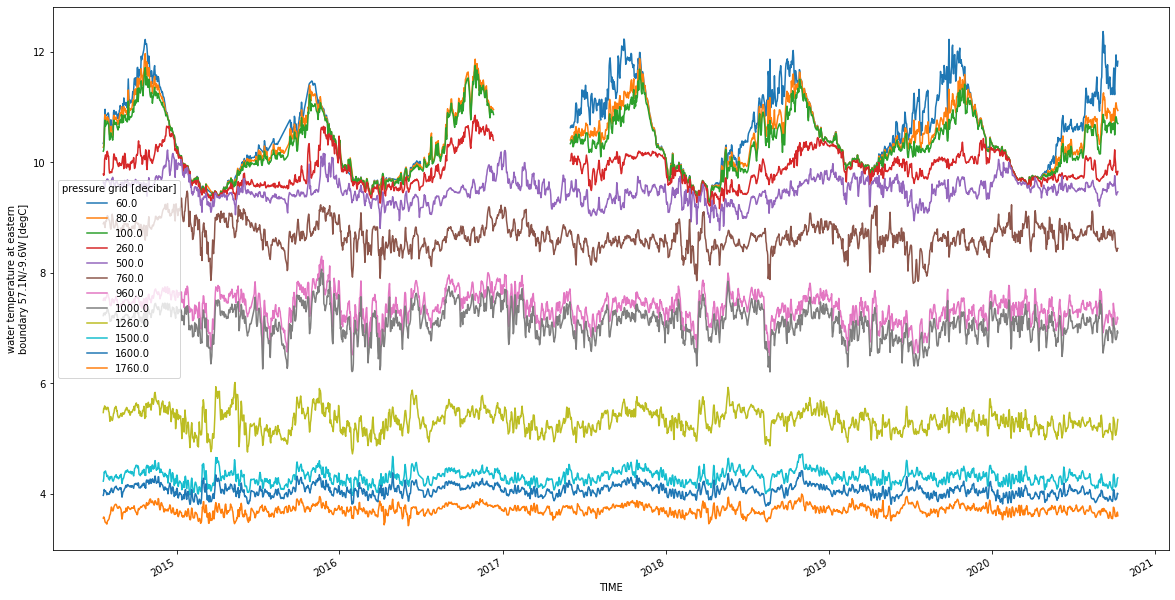

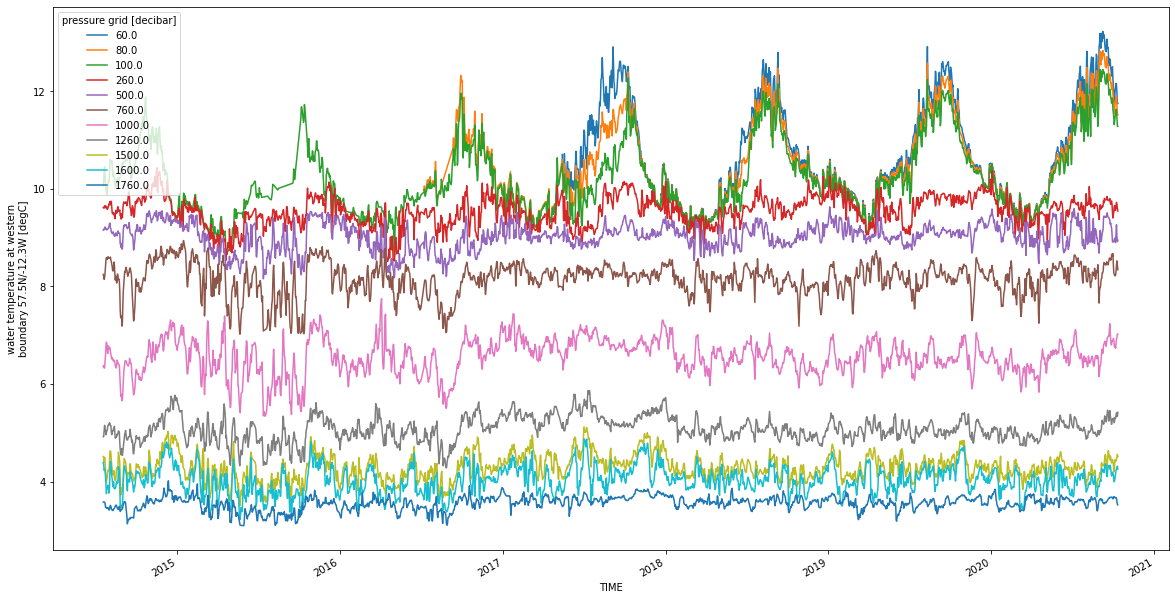

In [7]:
# create a mask for suspicious data in 2017
iper_60 = [np.datetime64('2016-07-01'),np.datetime64('2017-05-31')]
iper_80 = [np.datetime64('2016-12-12'),np.datetime64('2017-05-31')]
iper_100 = [np.datetime64('2016-12-12'),np.datetime64('2017-05-31')]
iper_260 = [np.datetime64('2016-12-12'),np.datetime64('2017-05-31')]
iper_clim = [np.datetime64('2016-06-01'),np.datetime64('2017-05-31')]
ds_eb = ds1D.sel(DEPTH=depth_EB,method='nearest').drop_vars(('TG_WEST_C'))
mask_eb = (ds_eb.TG_EAST_C==ds_eb.TG_EAST_C)
mask_eb = mask_eb.sel(DEPTH=depth_EB[4:],method='nearest')
mask_60 = (((ds_eb.sel(DEPTH=60).TIME<iper_60[0]) | (ds_eb.sel(DEPTH=60).TIME>iper_60[1])))
mask_80 = (((ds_eb.sel(DEPTH=80).TIME<iper_80[0]) | (ds_eb.sel(DEPTH=80).TIME>iper_80[1])))
mask_100 = (((ds_eb.sel(DEPTH=100).TIME<iper_100[0]) | (ds_eb.sel(DEPTH=100).TIME>iper_100[1])))
mask_260 = (((ds_eb.sel(DEPTH=260).TIME<iper_260[0]) | (ds_eb.sel(DEPTH=260).TIME>iper_260[1])))
mask_clim = (((ds_eb.sel(DEPTH=100).TIME<iper_clim[0]) | (ds_eb.sel(DEPTH=100).TIME>iper_clim[1])))
mask_clim = xr.concat([mask_clim,mask_clim,mask_clim,mask_clim,mask_eb],dim='DEPTH')
mask_eb = xr.concat([mask_60,mask_80,mask_100,mask_260,mask_eb],dim='DEPTH')
mask_clim.coords['DEPTH'] = mask_eb.DEPTH

ds1D.TG_EAST_C.where(mask_eb).plot.line(x='TIME',figsize=(20,10))
ds1D.sel(DEPTH=depth_WB,method='nearest').TG_WEST_C.plot.line(x='TIME',figsize=(20,10));

In [9]:
ds1D['TG_EAST_C'] = ds1D.TG_EAST_C.where(mask_eb)

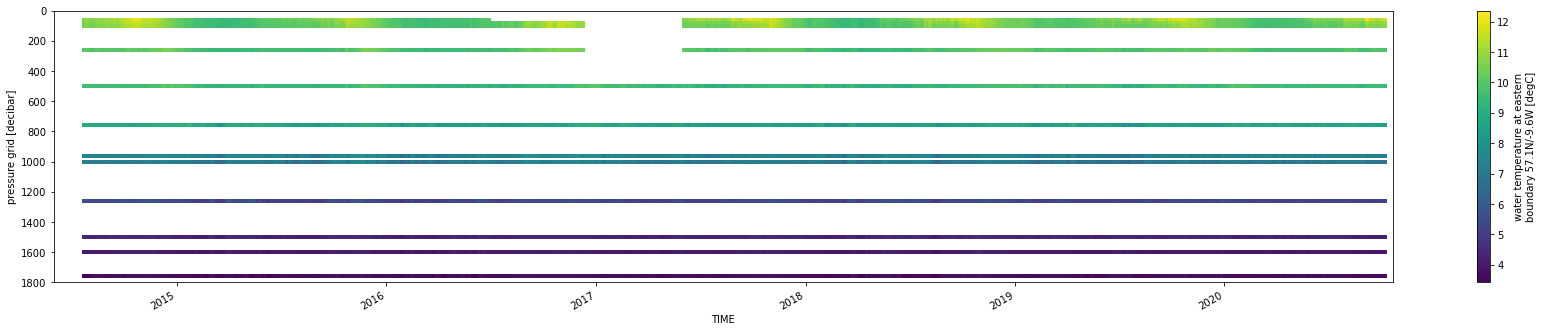

In [10]:
ds1D.TG_EAST_C.plot(x='TIME', figsize=(30,5), ylim=(1800,0));

# Function

In [11]:
def plt_parameters(data, bins):
    count, bins_count = np.histogram(data, bins=bins, range=[np.nanmin(data),np.nanmax(data)])
    pdf = count / sum(count)
    cdf = np.cumsum(pdf)
    return bins_count, pdf, cdf
    

# Distribution

In [ ]:
# EB
fig, ax = plt.subplots(len(depth_EB),6, figsize=(20,30))#, sharex=True, sharey=True)
fig.tight_layout()
m=0
for n in depth_EB:
    for y in [2014,2015,2016,2017,2018,2019]:
        y2 = y+1
        b = 0
        EB = np.array(ds1D.TG_EAST_C.sel(TIME=slice(f'{y}-09-01', f'{y2}-08-31')).sel(DEPTH=n, method='nearest'))
        EB_aut = np.array(ds1D.TG_EAST_C.sel(TIME=slice(f'{y}-09-01', f'{y}-11-30')).sel(DEPTH=n, method='nearest'))
        EB_wint = np.array(ds1D.TG_EAST_C.sel(TIME=slice(f'{y}-12-01', f'{y2}-02-28')).sel(DEPTH=n, method='nearest'))
        EB_spr = np.array(ds1D.TG_EAST_C.sel(TIME=slice(f'{y2}-03-01', f'{y2}-05-31')).sel(DEPTH=n, method='nearest'))
        EB_sum = np.array(ds1D.TG_EAST_C.sel(TIME=slice(f'{y2}-06-01', f'{y2}-08-31')).sel(DEPTH=n, method='nearest'))
        for t, bla in zip(['full Year', 'Autumn (SON)', 'Winter (DJF)', 'Spring (MAM)', 'Summer (JJA)'],[EB, EB_aut, EB_wint, EB_spr, EB_sum]):
            if any(~np.isnan(bla)):
                bins_count, pdf, cdf = plt_parameters(bla, 30)
                if t == ('full Year'):
                    ax[m,b].set_title(f'EB PDF {t} Depth {n}')
                    ax[m,b].plot(bins_count[1:], pdf, label=f"{y}")
                    ax[m,b].set_ylim(0,0.2)
                    ax[0,b].set_ylim(0,0.7)
                    ax[m,b].set_xlim(3,13)
                    ax[m,b].grid(True)
                    b=b+1
                ax[m,b].axhline(y = 0.1, color = 'r')
                ax[m,b].axhline(y = 0.9, color = 'r')
                ax[m,b].set_title(f'EB CDF {t} Depth {n}')
                ax[m,b].plot(bins_count[1:], cdf, label=f"{y}")
                ax[m,b].set_ylim(-0.05,1.05)
                ax[m,b].set_xlim(3,13)
                ax[m,b].grid(True)
            b=b+1
    ax[m,0].legend()        
    m=m+1;
#fig.savefig('figures/Stats/EB_stats_pdf+cdf_30bins', dpi = 300)

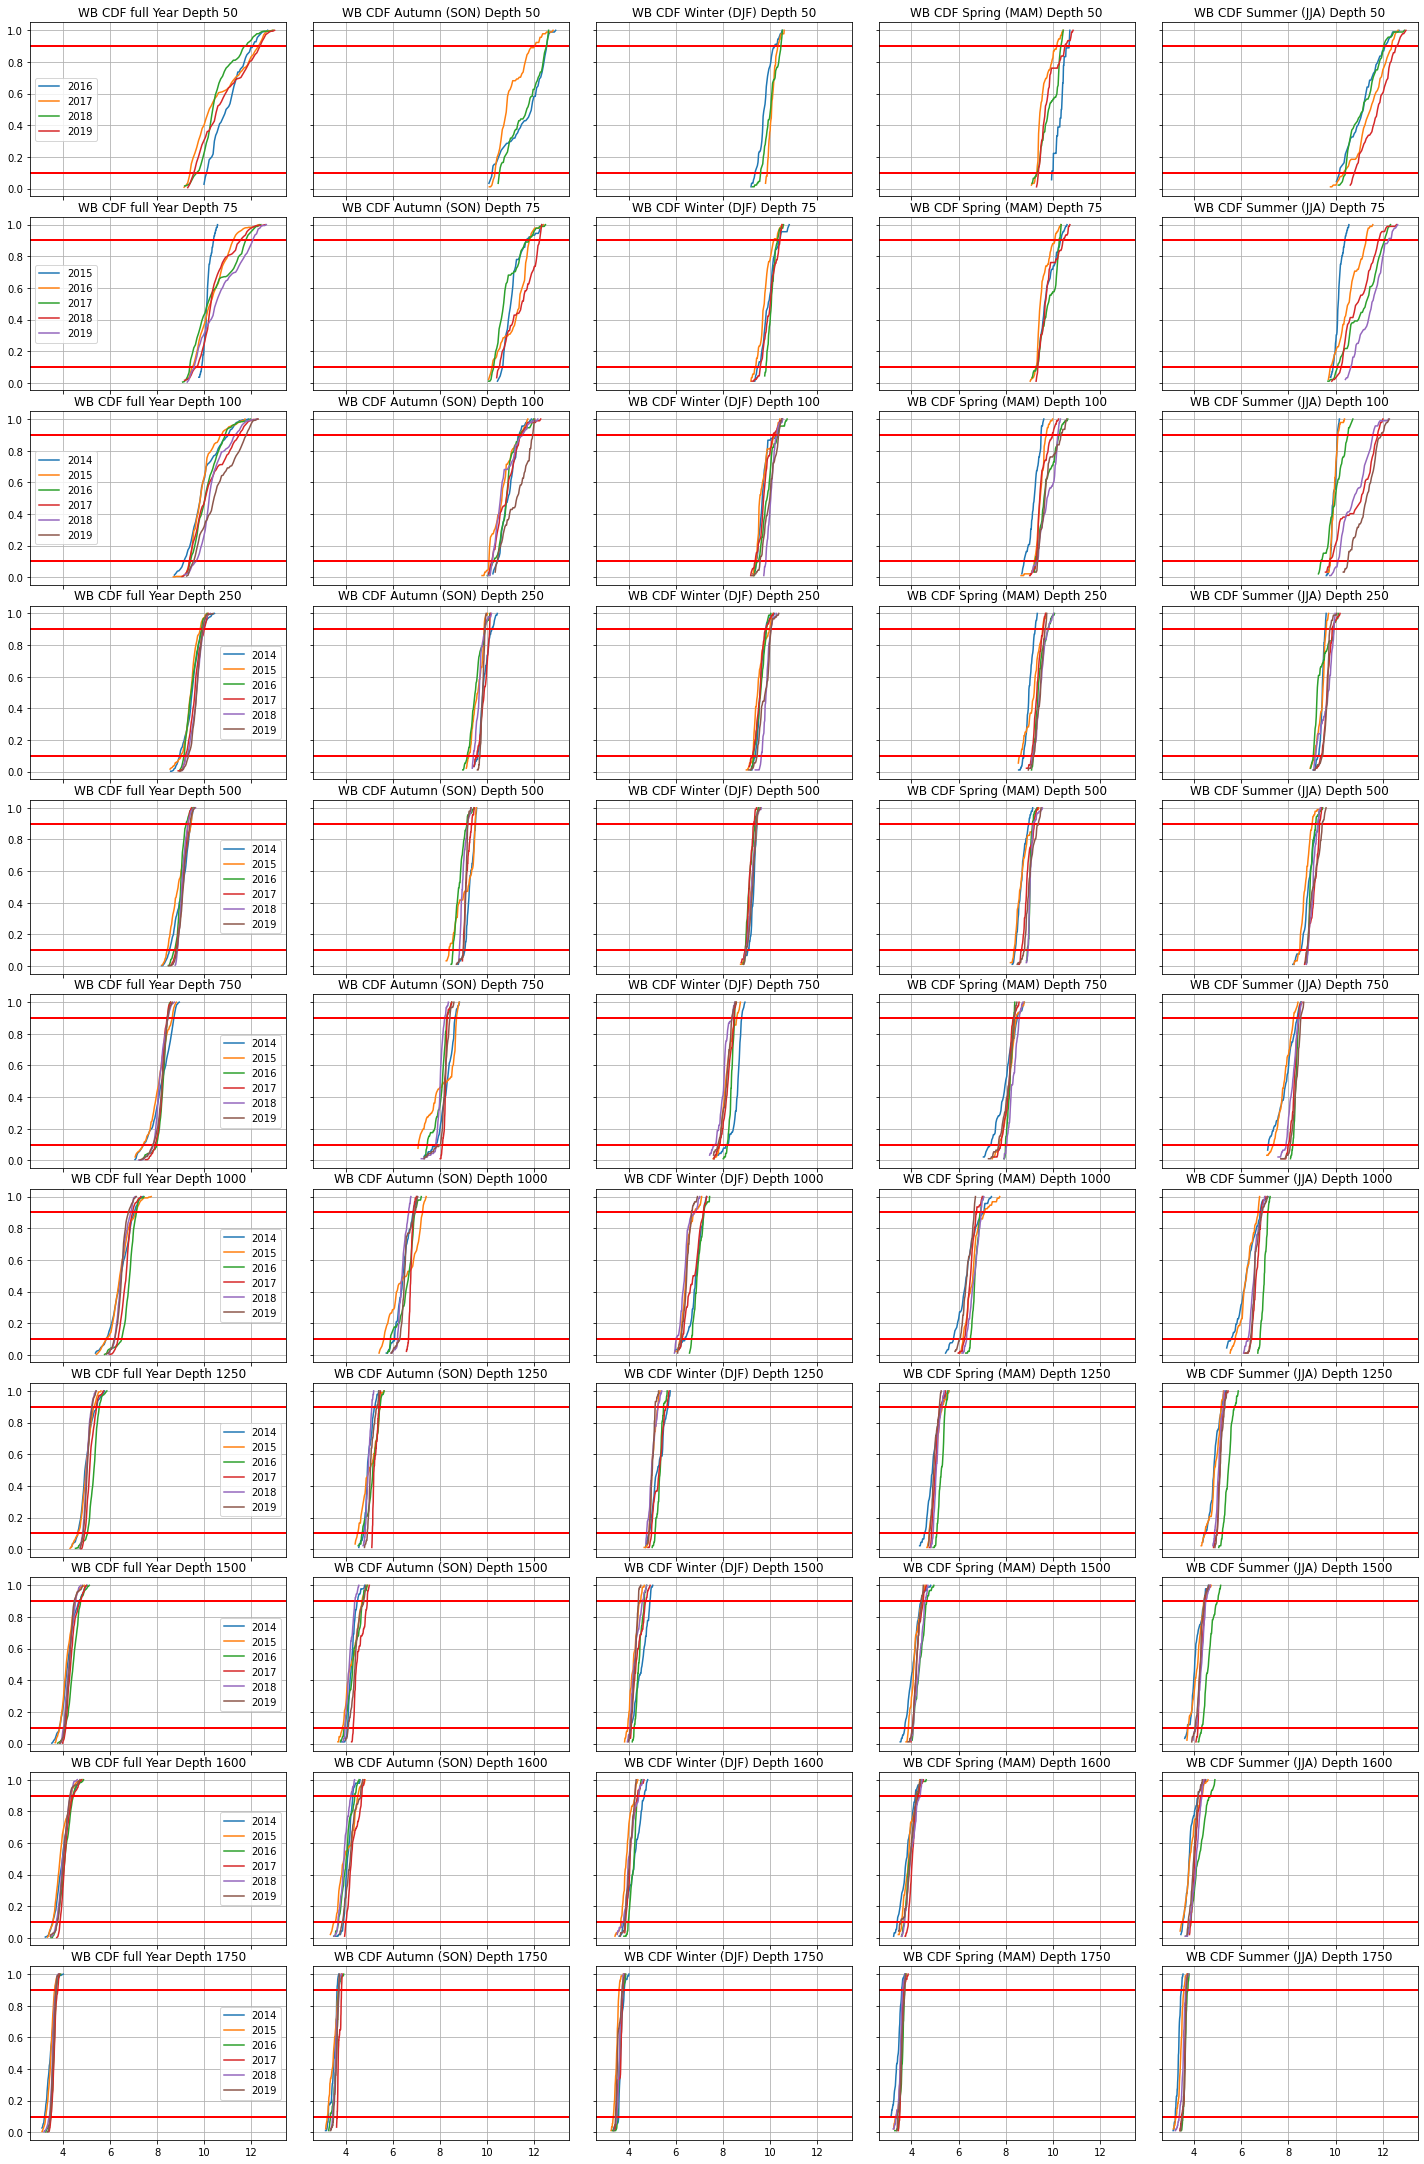

In [16]:
# WB
data = ds1D.TG_WEST_C
boundary = 'WB'
depth = depth_WB

fig, ax = plt.subplots(len(depth),5, figsize=(20,30), sharex=True, sharey=True)
fig.tight_layout()
m=0
for n in depth:
    for y in [2014,2015,2016,2017,2018,2019]:
        y2 = y+1
        b = 0
        year = np.array(data.sel(TIME=slice(f'{y}-09-01', f'{y2}-08-31')).sel(DEPTH=n, method='nearest'))
        autumn = np.array(data.sel(TIME=slice(f'{y}-09-01', f'{y}-11-30')).sel(DEPTH=n, method='nearest'))
        winter = np.array(data.sel(TIME=slice(f'{y}-12-01', f'{y2}-02-28')).sel(DEPTH=n, method='nearest'))
        spring = np.array(data.sel(TIME=slice(f'{y2}-03-01', f'{y2}-05-31')).sel(DEPTH=n, method='nearest'))
        summer = np.array(data.sel(TIME=slice(f'{y2}-06-01', f'{y2}-08-31')).sel(DEPTH=n, method='nearest'))
        for t, bla in zip(['full Year', 'Autumn (SON)', 'Winter (DJF)', 'Spring (MAM)', 'Summer (JJA)'],[year, autumn, winter, spring, summer]):
            if any(~np.isnan(bla)):
                bins_count, pdf, cdf = plt_parameters(bla, 50)
                #if t == ('full Year'):
                #    ax[m,b].set_title(f'{boundary} PDF {t} Depth {n}')
                #    ax[m,b].plot(bins_count[1:], pdf, label=f"{y}")
                #    ax[m,b].set_ylim(0,0.2)
                #    ax[0,b].set_ylim(0,0.7)
                #    ax[m,b].set_xlim(3,13)
                #    ax[m,b].grid(True)
                #    b=b+1
                ax[m,b].axhline(y = 0.1, color = 'r')
                ax[m,b].axhline(y = 0.9, color = 'r')
                ax[m,b].set_title(f'{boundary} CDF {t} Depth {n}')
                ax[m,b].plot(bins_count[1:], cdf, label=f"{y}")
                #ax[m,b].set_ylim(-0.05,1.05)
                #ax[m,b].set_xlim(3,13)
                ax[m,b].grid(True)
            b=b+1
    ax[m,0].legend()        
    m=m+1;
#fig.savefig('figures/Stats/WB_stats_cdf', dpi = 300)

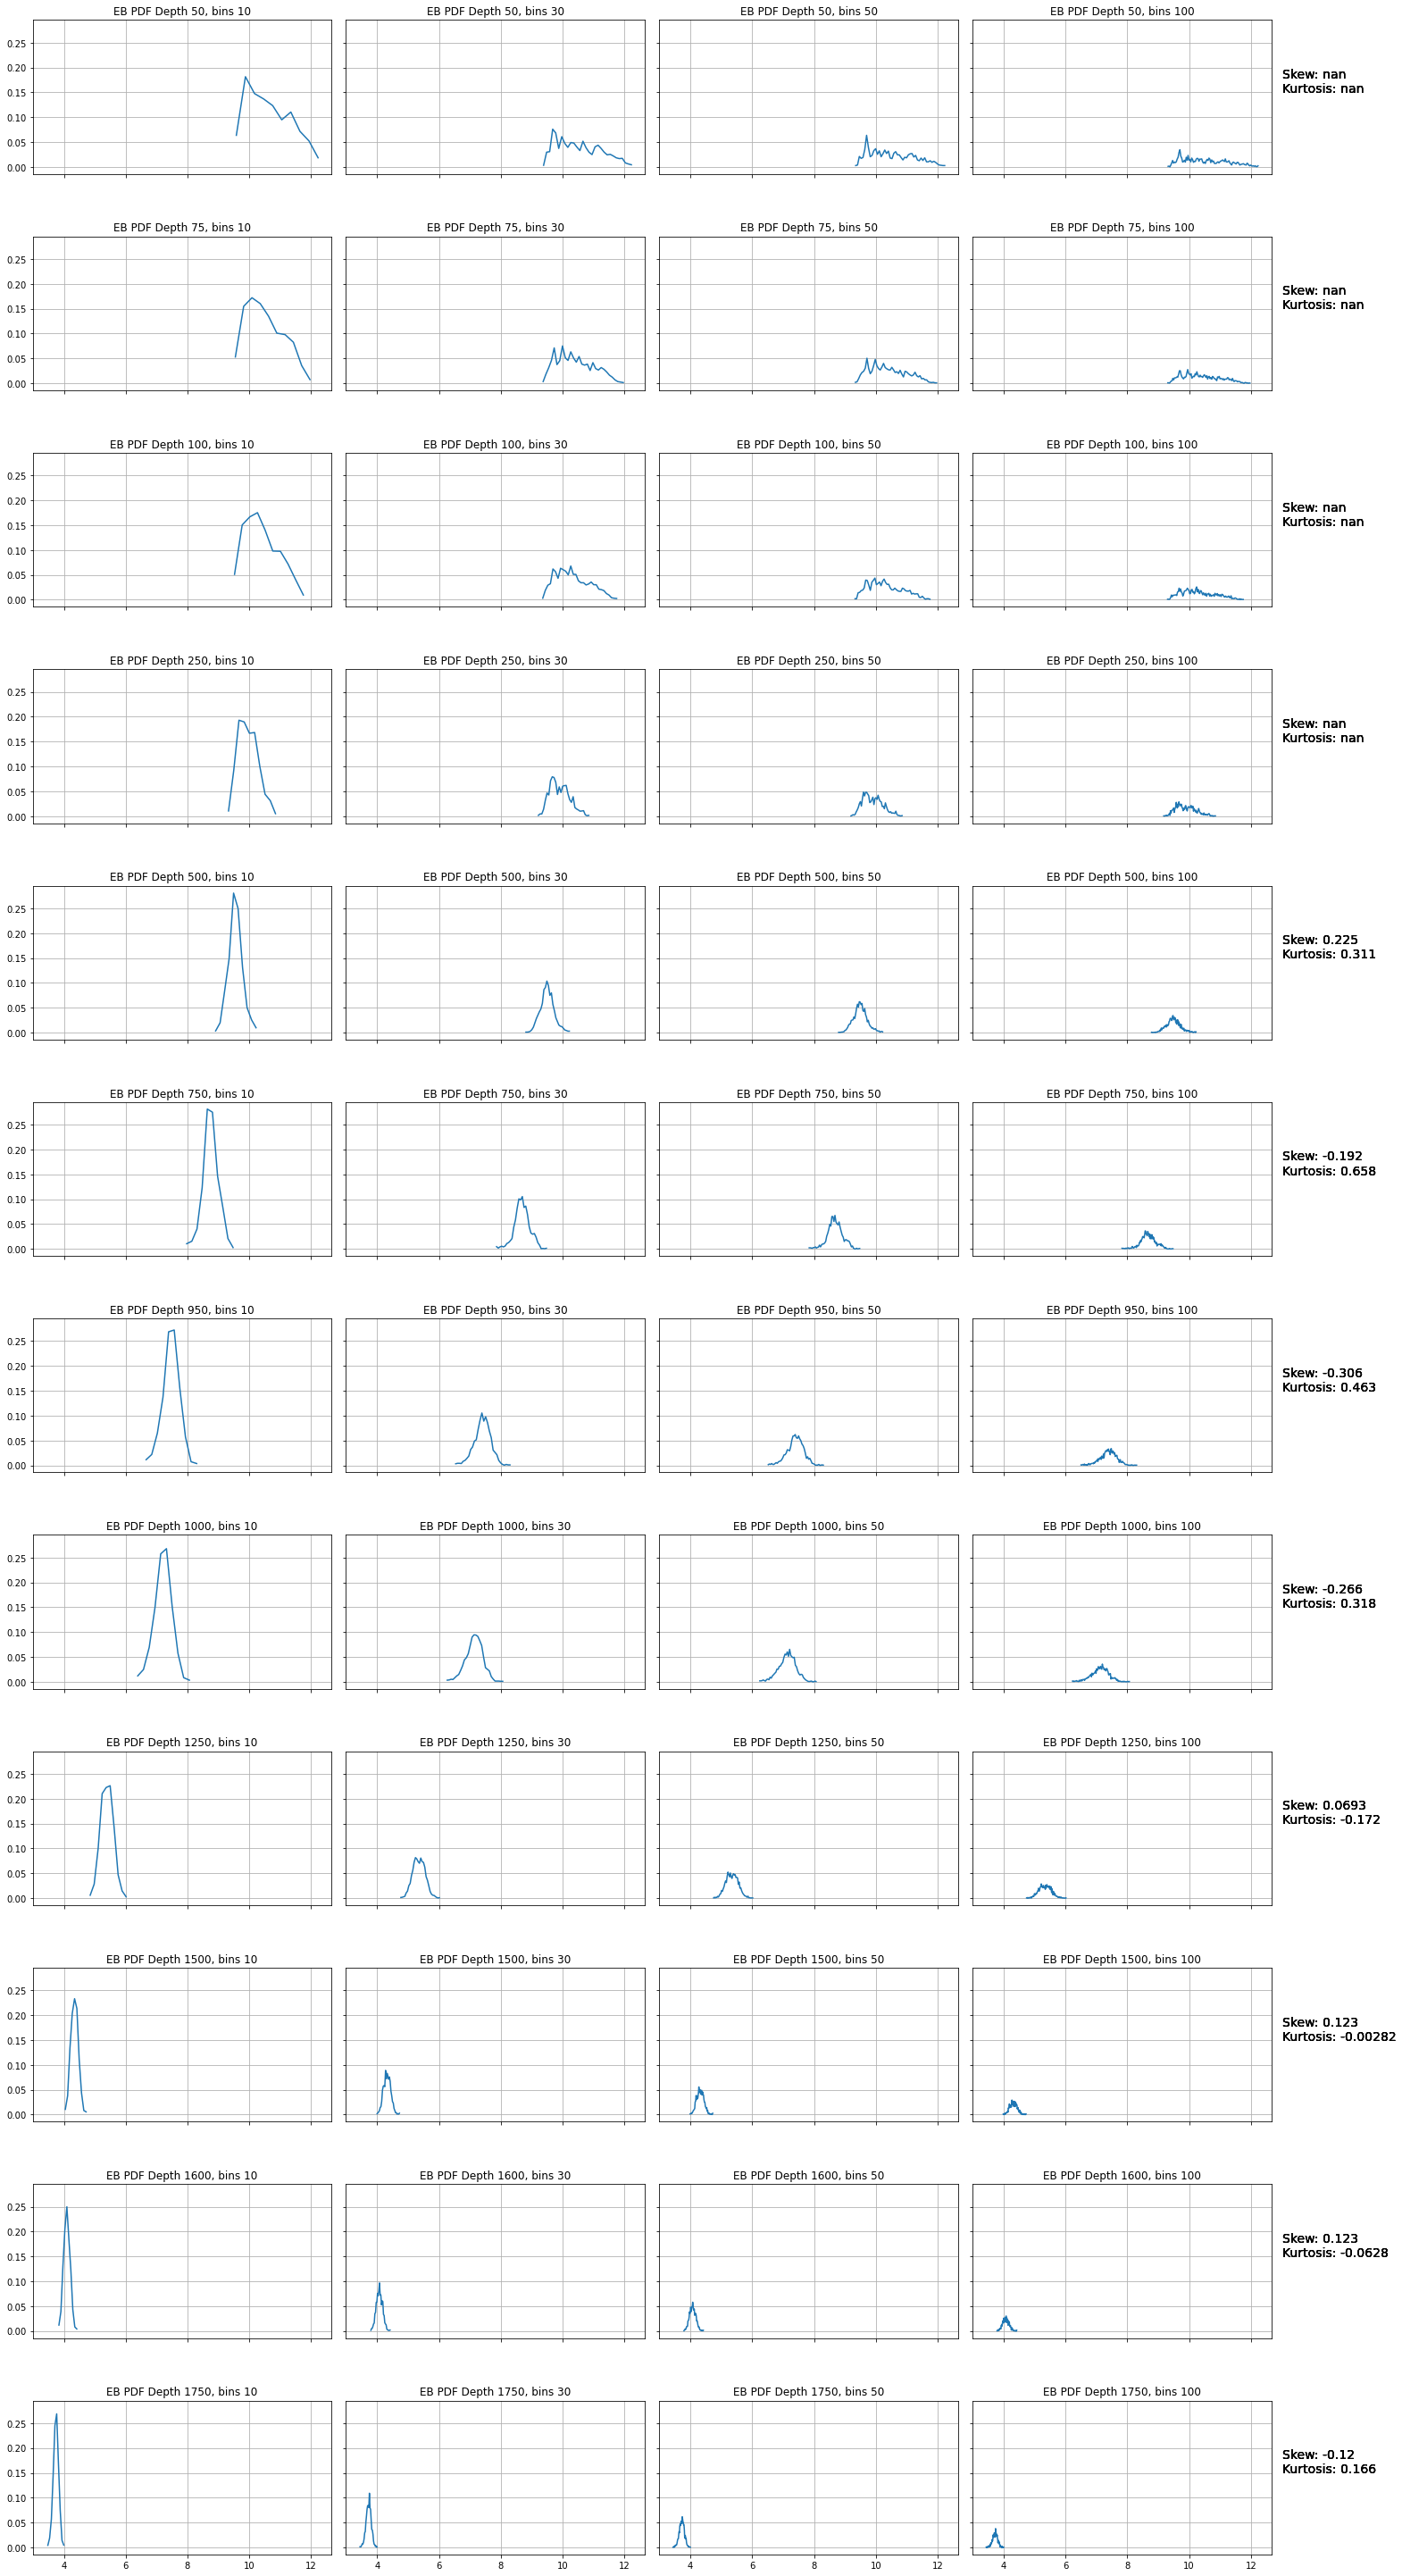

In [22]:
data = ds1D.TG_EAST_C
boundary = 'EB'
depth = depth_EB

fig, ax = plt.subplots(len(depth),4, figsize=(20,40), sharex=True, sharey=True)
fig.tight_layout(h_pad=6, w_pad=0)
b=0
for bins in [10,30,50,100]:
    m=0
    for n in depth:    
    #for y in [2014,2015,2016,2017,2018,2019]:
        #y2 = y+1
        year = np.array(data.sel(TIME=slice(f'2014-09-01', f'2020-08-31')).sel(DEPTH=n, method='nearest'))
        if any(~np.isnan(year)):
            bins_count, pdf, cdf = plt_parameters(year, bins)
            ax[m,b].set_title(f'{boundary} PDF Depth {n}, bins {bins}')
            ax[m,b].plot(bins_count[1:], pdf, label=f"{y}")
            ax[m,b].grid(True)

            skew = stats.skew(year)
            kurtosis = stats.kurtosis(year)
            ax[m,3].text(13, 0.15, f'Skew: {skew:.3} \nKurtosis: {kurtosis:.3}', fontsize= '14')
            #ax[m,b].legend()  
        m=m+1
    b=b+1
#fig.savefig('figures/Stats/EB_stats_pdf_different_bins_skew_kurtosis', dpi = 300, bbox_inches='tight')

#don't think this is actually that useful since it gives us the z-score and p-value but I think we are more interested 
#in the general skew and kurtosis
#skewtest = stats.skewtest(year) 
#kurtosistest = stats.kurtosistest(year)
